In [323]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [324]:

import random
import numpy as np

# Set seeds for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# For even more determinism (may slow down training)
tf.config.experimental.enable_op_determinism()
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [325]:
train_data = pd.read_csv('data/train.csv')
valid_data = pd.read_csv('data/valid.csv')
test_data = pd.read_csv('data/test.csv')

In [326]:
# 2. Map string labels to integers (right after loading)
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
train_data['label'] = train_data['label'].map(label_map)
valid_data['label'] = valid_data['label'].map(label_map)
test_data['label']  = test_data['label'].map(label_map)

# (Optional but recommended) drop rows with unmapped or NaN labels
train_data = train_data.dropna()
valid_data = valid_data.dropna()
test_data  = test_data.dropna()


In [327]:
# Ambil teks dan label
train_texts, train_labels = train_data['text'], train_data['label']
valid_texts, valid_labels = valid_data['text'], valid_data['label']
test_texts,  test_labels  = test_data['text'],  test_data['label']

In [328]:
from tensorflow.keras.layers import TextVectorization

# Buat vectorizer berdasarkan training saja
vectorizer = TextVectorization(max_tokens=20000, output_mode="int", output_sequence_length=100)
vectorizer.adapt(train_texts)

In [329]:
# Siapkan dataset TensorFlow
batch_size = 32
train_ds = tf.data.Dataset.from_tensor_slices((train_texts, train_labels)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((valid_texts, valid_labels)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((test_texts,  test_labels)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [330]:
# Add this before training to check data types
print("Sample text:", train_texts.iloc[0])
print("Sample label:", train_labels.iloc[0], "Type:", type(train_labels.iloc[0]))

# Check the shape and first few elements of each dataset
print("\nFirst batch of train_ds:")
for text_batch, label_batch in train_ds.take(1):
    print("Text shape:", text_batch.shape)
    print("Label shape:", label_batch.shape)
    print("Label values:", label_batch.numpy())

Sample text: Nikmati cicilan 0% hingga 12 bulan untuk pemesanan tiket pesawat air asia dengan kartu kredit bni!
Sample label: 1 Type: <class 'numpy.int64'>

First batch of train_ds:
Text shape: (32,)
Label shape: (32,)
Label values: [1 2 1 2 2 1 1 0 0 2 2 0 0 2 2 2 1 1 1 0 1 2 2 0 1 0 0 0 0 2 2 1]


In [331]:
# Import required modules
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding, SimpleRNN, Bidirectional, Dropout, Dense, Input


model = Sequential([
    Input(shape=(1,), dtype=tf.string),
    vectorizer,
    Embedding(input_dim=20000, output_dim=128, mask_zero=True),
    Bidirectional(SimpleRNN(64)),
    Dropout(0.5),
    Dense(3, activation="softmax")
])

In [332]:
print(model.summary())

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_20           │ (None, 100)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_18 (Embedding)        │ (None, 100, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_18                │ (None, 128)            │        24,704 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,585,091 (9.86 MB)

 Trainable params: 2,585,091 (9.86 MB)

 Non-trainable params: 0 (0.00 B)

None


In [333]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [334]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(train_ds, validation_data=valid_ds, epochs=100, callbacks=[early_stopping])


# Evaluasi akhir
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nAkurasi akhir pada test set: {test_acc:.4f}")

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.4217 - loss: 1.0480 - val_accuracy: 0.5100 - val_loss: 0.9953
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8681 - loss: 0.6760 - val_accuracy: 0.5100 - val_loss: 1.0112
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9690 - loss: 0.3723 - val_accuracy: 0.5400 - val_loss: 0.9046
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9818 - loss: 0.1778 - val_accuracy: 0.4800 - val_loss: 1.0455
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9928 - loss: 0.0978 - val_accuracy: 0.6400 - val_loss: 0.8403
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9979 - loss: 0.0401 - val_accuracy: 0.6200 - val_loss: 0.9208
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0229 - val_accuracy: 0.6600 - val_loss: 0.9073
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0134 - val_accuracy: 0.

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Macro F1-Score: 0.6315

Classification Report:
              precision    recall  f1-score   support

    Negative       0.57      0.67      0.61       153
     Neutral       0.58      0.44      0.50        96
    Positive       0.79      0.77      0.78       151

    accuracy                           0.65       400
   macro avg       0.65      0.63      0.63       400
weighted avg       0.65      0.65      0.65       400



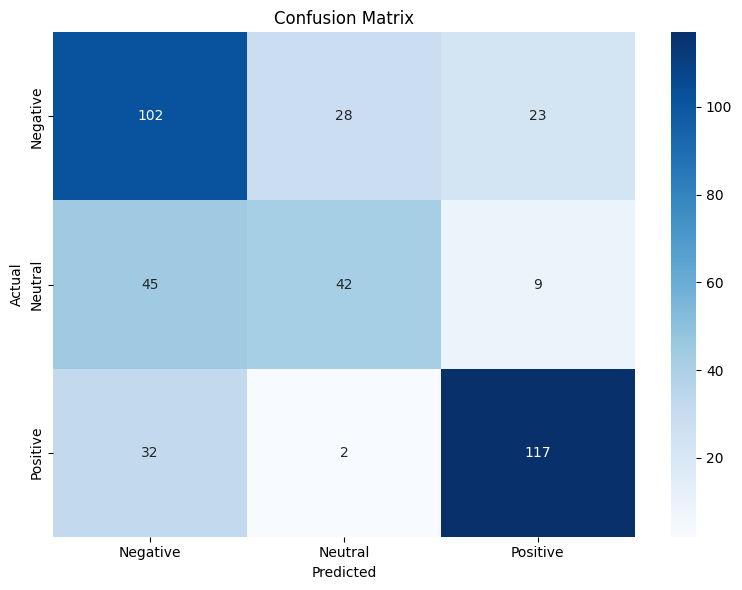

In [335]:
# Import necessary metrics
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions on test set
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels from test dataset (need to extract from the TensorFlow dataset)
test_labels_list = []
for _, labels in test_ds:
    test_labels_list.append(labels.numpy())
y_true = np.concatenate(test_labels_list, axis=0)
y_true = y_true[:len(y_pred)]  # Match lengths in case of incomplete batches

# Calculate macro F1-score
f1_macro = f1_score(y_true, y_pred, average='macro')
print(f"\nMacro F1-Score: {f1_macro:.4f}")

# Get detailed classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, 
                          target_names=['Negative', 'Neutral', 'Positive']))

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

## Load Keras Model

In [336]:
model.save('models/keras_model_rnn.h5')

In [337]:
keras_model_rnn = tf.keras.models.load_model('models/keras_model_rnn.h5')

In [338]:
from loadRNN import load_scratch_model

ScratchModel = load_scratch_model(keras_model_rnn)

Embedding
Bidirectional
creating new bidirectional layer
Dropout
creating new dropout layer
Dense
creating new dense layer


## Predict Scratch Model

In [339]:

from predictRNN import predict

preds = predict(ScratchModel, test_texts)

Using vectorizer from global scope
Processing batch 1/13
  Layer 1: EmbeddingWrapper
  Layer 2: Bidirectional
  Layer 3: Dropout
  Layer 4: Dense
Processing batch 2/13
  Layer 1: EmbeddingWrapper
  Layer 2: Bidirectional
  Layer 3: Dropout
  Layer 4: Dense
Processing batch 3/13
  Layer 1: EmbeddingWrapper
  Layer 2: Bidirectional
  Layer 3: Dropout
  Layer 4: Dense
Processing batch 4/13
  Layer 1: EmbeddingWrapper
  Layer 2: Bidirectional
  Layer 3: Dropout
  Layer 4: Dense
Processing batch 5/13
  Layer 1: EmbeddingWrapper
  Layer 2: Bidirectional
  Layer 3: Dropout
  Layer 4: Dense
Processing batch 6/13
  Layer 1: EmbeddingWrapper
  Layer 2: Bidirectional
  Layer 3: Dropout
  Layer 4: Dense
Processing batch 7/13
  Layer 1: EmbeddingWrapper
  Layer 2: Bidirectional
  Layer 3: Dropout
  Layer 4: Dense
Processing batch 8/13
  Layer 1: EmbeddingWrapper
  Layer 2: Bidirectional
  Layer 3: Dropout
  Layer 4: Dense
Processing batch 9/13
  Layer 1: EmbeddingWrapper
  Layer 2: Bidirectional
  

In [340]:
preds_classes = np.argmax(preds, axis=1)


# Hitung Macro F1
scratch_macro_f1 = f1_score(test_labels, preds_classes, average='macro')
print("Macro F1-Score on Test Set:", scratch_macro_f1)

Macro F1-Score on Test Set: 0.38307747879181414
